# Model testing

Evaluate the saved XGBoost regressor on the held-out test dataset.

### Imports

In [1]:
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


### Variables

In [2]:
target_col = "movie_score"
drop_cols = ["movie_score", "averageRating", "numVotes", "Unnamed: 0", "_orig_order"]

### Retrieve data

In [3]:
useBackslash = True
testDatasetPath = r'.\data\test_dataset.csv' if useBackslash else r'./data/test_dataset.csv'
final_model = joblib.load("xgb_reg_movie_number_votes_tweedie.joblib")
df_test = pd.read_csv(testDatasetPath, sep=";")


### Prepare test data

In [4]:
# Load model and data, transform the log scalled data back
y_true = np.expm1(df_test[target_col].values)
X_test = df_test.drop(columns=[c for c in drop_cols if c in df_test.columns])


### Create prediction on test

In [5]:
# Predict and turn the prediction back to normal scale 
y_pred = np.expm1(final_model.predict(X_test))

c:\Users\ander\AppData\Local\Programs\Python\Python314\Lib\site-packages\xgboost\core.py:774: UserWarning: [20:54:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


### Calculate MAE, RMSE and R^2

In [6]:
# Metrics (only if ground truth available)
if y_true is not None:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2:   {r2:.4f}")
else:
    print("Ground-truth 'movie_score' not found in test set; only predictions are available.")


MAE:  2226.0608
RMSE: 19833.7176
R2:   0.2803


In [7]:
# --- Bin-based evaluation ---
bin_edges = [0, 10, 50, 100, 500, 1000, 5000, 10000, 20000, 40000, np.inf]
bin_labels = ["0-10", "10-50", "50-100", "100-500", "500-1000", "1000-5000", "5000-10000", "10000-20000", "20000-40000", "40000+"]

eval_df = pd.DataFrame({
    "y_true": y_true,
    "y_pred": y_pred
})

# Put each row into a bin based on TRUE score (recommended)
eval_df["score_bin"] = pd.cut(
    eval_df["y_true"],
    bins=bin_edges,
    labels=bin_labels,
    right=False,          # [low, high)
    include_lowest=True
)

def metrics_for_slice(y_t, y_p):
    return {
        "n": len(y_t),
        "mae": mean_absolute_error(y_t, y_p),
        "rmse": np.sqrt(mean_squared_error(y_t, y_p)),
        "mean_true": float(np.mean(y_t)),
        "mean_pred": float(np.mean(y_p)),
        "median_abs_err": float(np.median(np.abs(y_p - y_t))),
    }

bin_results = (
    eval_df.dropna(subset=["score_bin"])
           .groupby("score_bin", observed=True)
           .apply(lambda g: pd.Series(metrics_for_slice(g["y_true"].values, g["y_pred"].values)))
           .reset_index()
)

print("\nPer-bin performance (binned by TRUE movie_score):")
print(bin_results.to_string(index=False))



Per-bin performance (binned by TRUE movie_score):
  score_bin       n          mae          rmse     mean_true    mean_pred  median_abs_err
       0-10  5545.0    68.803833   1045.849850      7.424166    76.227997       25.685398
      10-50 21845.0    92.201695   1114.204157     23.738567   113.736794       23.247448
     50-100  8247.0   135.730519    728.601295     70.671759   177.472580       37.109394
    100-500 14836.0   354.512527   2725.498150    233.517660   418.129272      126.494812
   500-1000  4343.0   837.671832   2790.002079    706.105227   867.792114      484.628704
  1000-5000  6395.0  2432.891246   9044.426059   2189.017201  2116.279297     1369.807770
 5000-10000  1255.0  7269.105169  17925.225649   7028.812749  6347.584961     5206.963043
10000-20000   852.0 13805.581636  25626.454788  14081.359155 11607.870117    10596.876953
20000-40000   544.0 24722.459306  34429.496047  28386.556985 20639.419922    21229.709412
     40000+   838.0 97519.219089 166169.574546 13

C:\Users\ander\AppData\Local\Temp\ipykernel_22756\309687552.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series(metrics_for_slice(g["y_true"].values, g["y_pred"].values)))


In [8]:
bin_results.to_csv(r'.\data\performance_binned_by_true.csv', sep=';')

In [9]:
eval_df["pred_bin"] = pd.cut(
    eval_df["y_pred"],
    bins=bin_edges,
    labels=bin_labels,
    right=False,
    include_lowest=True
)

pred_bin_results = (
    eval_df.dropna(subset=["pred_bin"])
           .groupby("pred_bin", observed=True)
           .apply(lambda g: pd.Series(metrics_for_slice(g["y_true"].values, g["y_pred"].values)))
           .reset_index()
)

print("\nPer-bin performance (binned by PREDICTED movie_score):")
print(pred_bin_results.to_string(index=False))



Per-bin performance (binned by PREDICTED movie_score):
   pred_bin       n          mae          rmse     mean_true     mean_pred  median_abs_err
       0-10     4.0     6.578167     10.234478     13.000000      9.536020        2.542004
      10-50 22608.0    88.518865    636.112691    100.087491     31.948547       18.894657
     50-100 13072.0   221.641201   1164.985057    243.239214     70.516876       49.046095
    100-500 17699.0   601.083732   3508.363323    676.292954    225.110367      145.668472
   500-1000  4020.0  1616.091930   6513.271946   1822.573881    705.116943      520.214600
  1000-5000  4762.0  4796.794534  17674.991054   5413.557119   2167.401611     1350.190247
 5000-10000   940.0 10506.163222  23303.008151  12357.528723   6996.797363     5039.845459
10000-20000   596.0 19248.942622  37530.997065  23518.273490  14079.768555    10173.248535
20000-40000   359.0 40861.023666  85933.905852  47368.381616  28305.085938    20207.843750
     40000+   640.0 98644.849365 1

C:\Users\ander\AppData\Local\Temp\ipykernel_22756\1288564663.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series(metrics_for_slice(g["y_true"].values, g["y_pred"].values)))


In [10]:
pred_bin_results.to_csv(r'.\data\performance_binned_by_predicted.csv', sep=';')

### Create a preview dataframe

In [11]:
# Preview predictions
preview = pd.DataFrame({"predicted_movie_score": y_pred, "residual": abs(y_pred - y_true)})
if y_true is not None:
    preview.insert(0, "actual_movie_score", y_true)


### Create a dataframe of feature importance

In [12]:
importances = final_model.feature_importances_

# Feature names (if trained with a DataFrame)
feature_names = final_model.feature_names_in_

# Create sorted DataFrame
features = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
)

In [13]:
features.to_csv(r'.\data\feature_importance.csv', sep=';')

### Graph over residuals

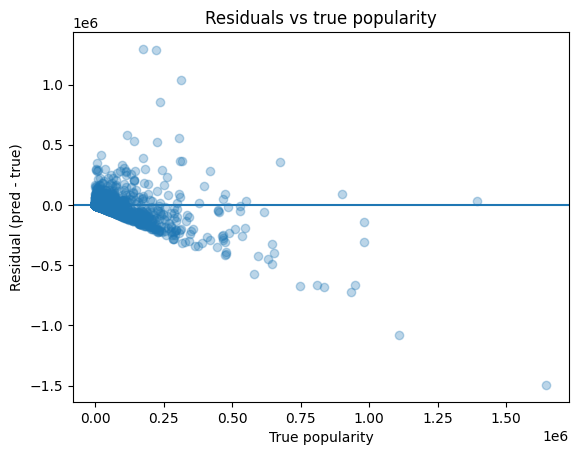

In [14]:
residuals = y_pred - y_true

plt.figure()
plt.scatter(y_true, residuals, alpha=0.3)
plt.axhline(0)
plt.xlabel("True popularity")
plt.ylabel("Residual (pred - true)")
plt.title("Residuals vs true popularity")
plt.show()


### Bias plot

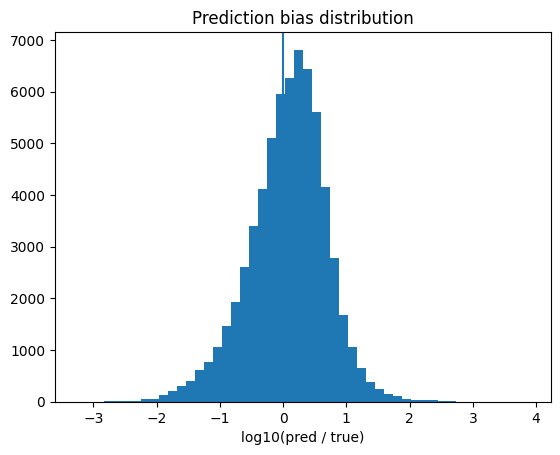

In [15]:
ratio = y_pred / (y_true + 1e-9)
plt.figure()
plt.hist(np.log10(ratio), bins=50)
plt.axvline(0)  # log10(1)
plt.xlabel("log10(pred / true)")
plt.title("Prediction bias distribution")
plt.show()

